In [ ]:
from typing import Callable, List, Tuple, Dict, Any
import yfinance as yf
from pandas import DataFrame, Series
from datetime import datetime

class Backtester:
  def __init__(self, strategy: Callable):
    self.strategy = strategy


  def testTickerReport(self, ticker: str, start: str, end: str, startingAmount: float = 1000000.00) -> Dict[str, Any]: # returns a tuple of a dictionary of dates and prices, and a list of returns
    stock = yf.Ticker(ticker)
    data = stock.history(start=start, end=end)
    data = data['Close'].to_list()
    return self.testCustomReport(data, start, end, startingAmount)

  @staticmethod
  def getRatios(pctChanges: List[float], maxDrawdown: float, overallReturn: float, n: int) -> List[float]:
    pct = Series(pctChanges)
    riskFreeRate = yf.download('^IRX', start=pct.index[0], end=pct.index[-1])['Close'].pct_change().mean()

    sharpe = (overallReturn-riskFreeRate)/pct.std()
    sortino = (overallReturn-riskFreeRate)/pct[pct < 0].std()
    calmar = overallReturn/maxDrawdown
    return [sharpe, sortino, calmar]


  def testCustomReport(self, data: List[float], start: str, end: str, startingAmount: float = 1000000.00) -> float:
    signals = self.strategy(data)
    amt = startingAmount
    histArr = []
    trades = []
    drawdowns = []
    bought = False
    boughtPrice = 0
    shares = 0
    prev = 0
    for price, signal in zip(data, signals):
      if prev != signal:
        if signal: # Buying a stock
          bought = True
          boughtPrice = minPrice = price
          currentDuration = 0
          currentDrawdownDuration = 0
          shares = int(amt/price)
          amt -= shares * price
        else: # Selling a stock
          bought = False
          trades.append((currentDuration, (price-boughtPrice)/boughtPrice))
          drawdowns.append((minPrice-price)/price)
          amt += price * shares
          shares = 0
      if bought:
        if price < boughtPrice:
          currentDrawdownDuration += 1
        else:
          drawdowns.append((currentDrawdownDuration, (minPrice-price)/price))
          currentDrawdownDuration = 0

        currentDuration += 1
        minPrice = min(minPrice, price)
      prev = signal
      histArr.append(shares*price+amt)
    totals = histArr
    
    report = {}
    report['Start'] = start
    report['End'] = end
    report['Duration'] = len(totals)
    report['Exposure Time'] = sum([x[0] for x in trades])/len(trades)
    report['Net Worth'] = totals

    report['Equity Final'] = totals[-1]
    report['Equity Peak'] = max(totals)

    report['Return'] = (totals[-1]-startingAmount)/startingAmount
    report['Buy and Hold Return'] = (data[-1]-data[0])/data[0]

    report['Max Drawdown'] = min(d[1] for d in drawdowns)
    report['Avg Drawdown'] = sum(d[1] for d in drawdowns)/len(drawdowns)
    report["Max Drawdown Duration"] = max(d[0] for d in drawdowns)
    report["Avg Drawdown Duration"] = sum(d[0] for d in drawdowns)/len(drawdowns)
    
    report["# Trades"] = len(trades)
    report["Win Rate"] = sum(1 for t in trades if t[1] > 0)/len(trades)
    report["Best Trade"] = max(t[1] for t in trades)
    report["Worst Trade"] = min(t[1] for t in trades)

    report["Max Trade Duration"] = max(t[0] for t in trades)
    report["Avg Trade Duration"] = sum(t[0] for t in trades)/len(trades)

    report["Sharpe Ratio"], report["Sortino Ratio"], report["Calmar Ratio"] = self.getRatios([x[1] for x in trades], report["Max Drawdown"], report["Return"], len(trades))
    
    return report

  def graphTicker(self, ticker: str, start: str, end: str) -> None:
    pass

  def graphCustom(self, data: List[float]) -> None:
    pass

# How to factor in a look back period for a potential strategy
# Data clean up and organization between different sources

In [ ]:
from typing import Callable, List, Tuple, Dict, Any
import yfinance as yf
from pandas import DataFrame
from datetime import datetime

class Backtester:
  def __init__(self, strategy: Callable):
    self.strategy = strategy

  def testTicker(self, ticker: str, start: str, end: str, startingAmount: float = 1000000.00) -> List[float]: # takes in ticker symbol, start date, end date
    stock = yf.Ticker(ticker)
    data = stock.history(start=start, end=end)
    data = data['Close'].to_list()
    signals = self.strategy(data)

    amt = startingAmount
    histArr = []
    shares = 0
    prev = 0
    for price, signal in zip(data, signals):
      if prev != signal:
        if signal:
          shares = int(amt/price)
          amt -= shares * price
        else:
          amt += price * shares
          shares = 0
      prev = signal
      histArr.append(shares*price+amt)

    return histArr


  def testTickerReport(self, ticker: str, start: str, end: str, startingAmount: float = 1000000.00) -> Dict[str, Any]: # returns a tuple of a dictionary of dates and prices, and a list of returns
    stock = yf.Ticker(ticker)
    data = stock.history(start=start, end=end)
    data = data['Close'].to_list()
    signals = self.strategy(data)

    amt = startingAmount
    histArr = []
    trades = []
    drawdowns = []
    bought = False
    boughtPrice = 0
    shares = 0
    prev = 0
    for price, signal in zip(data, signals):
      if prev != signal:
        if signal: # Buying a stock
          bought = True
          boughtPrice = minPrice = price
          currentDuration = 0
          currentDrawdownDuration = 0
          shares = int(amt/price)
          amt -= shares * price
        else: # Selling a stock
          bought = False
          trades.append((currentDuration, (price-boughtPrice)/boughtPrice))
          drawdowns.append((minPrice-price)/price)
          amt += price * shares
          shares = 0
      if bought:
        if price < boughtPrice:
          currentDrawdownDuration += 1
        else:
          drawdowns.append((currentDrawdownDuration, (minPrice-price)/price))
          currentDrawdownDuration = 0

        currentDuration += 1
        minPrice = min(minPrice, price)
      prev = signal
      histArr.append(shares*price+amt)
    totals = histArr
    
    report = {}
    report['Start'] = start
    report['End'] = end
    report['Duration'] = len(totals)
    report['Exposure Time'] = sum([x[0] for x in trades])/len(trades)
    report['Net Worth'] = totals

    report['Equity Final'] = totals[-1]
    report['Equity Peak'] = max(totals)

    report['Return'] = (totals[-1]-startingAmount)/startingAmount
    report['Buy and Hold Return'] = (data[-1]-data[0])/data[0]

    report['Max Drawdown'] = min(d[1] for d in drawdowns)
    report['Avg Drawdown'] = sum(d[1] for d in drawdowns)/len(drawdowns)
    report["Max Drawdown Duration"] = max(d[0] for d in drawdowns)
    report["Avg Drawdown Duration"] = sum(d[0] for d in drawdowns)/len(drawdowns)
    
    report["# Trades"] = len(trades)
    report["Win Rate"] = sum(1 for t in trades if t[1] > 0)/len(trades)
    report["Best Trade"] = max(t[1] for t in trades)
    report["Worst Trade"] = min(t[1] for t in trades)

    report["Max Trade Duration"] = max(t[0] for t in trades)
    report["Avg Trade Duration"] = sum(t[0] for t in trades)/len(trades)
    
    return report


  def testCustom(self, data: List[float], start: str, end: str, startingAmount: float = 1000000.00) -> float:
    signals = self.strategy(data)

    amt = startingAmount
    histArr = []
    shares = 0
    prev = 0
    for price, signal in zip(data, signals):
      if prev != signal:
        if signal:
          shares = int(amt/price)
          amt -= shares * price
        else:
          amt += price * shares
          shares = 0
      prev = signal
      histArr.append(shares*price+amt)

      return histArr

  def testCustomReport(self, data: List[float]) -> Tuple[Dict[str, float], List[float]]:
    pass

  def graphTicker(self, ticker: str, start: str, end: str) -> None:
    pass

  def graphCustom(self, data: List[float]) -> None:
    pass

# How to factor in a look back period for a potential strategy
# Data clean up and organization between different sources

In [ ]:
prim = yf.download("AAPL", start=datetime.datetime(y, m, d), end=datetime.date.today())[-period-window_size:]


In [ ]:
def momentum(ma1, ma2, df):
  pass

def wrapper(df):
  return momentum(50, 200, df)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,72.246685,73.310001,71.990615,73.249031,135480400,0.0,0.0
2020-01-03 00:00:00-05:00,72.468595,73.305097,72.310075,72.536880,146322800,0.0,0.0
2020-01-06 00:00:00-05:00,71.649176,73.153905,71.395540,73.114883,118387200,0.0,0.0
2020-01-07 00:00:00-05:00,73.124647,73.383158,72.549096,72.771027,108872000,0.0,0.0
2020-01-08 00:00:00-05:00,72.471061,74.246499,72.471061,73.941650,132079200,0.0,0.0
...,...,...,...,...,...,...,...
2020-12-23 00:00:00-05:00,130.037521,130.303174,128.679679,128.856796,88223700,0.0,0.0
2020-12-24 00:00:00-05:00,129.211031,131.316662,128.994563,129.850586,54930100,0.0,0.0
2020-12-28 00:00:00-05:00,131.838131,135.134321,131.365829,134.494766,124486200,0.0,0.0


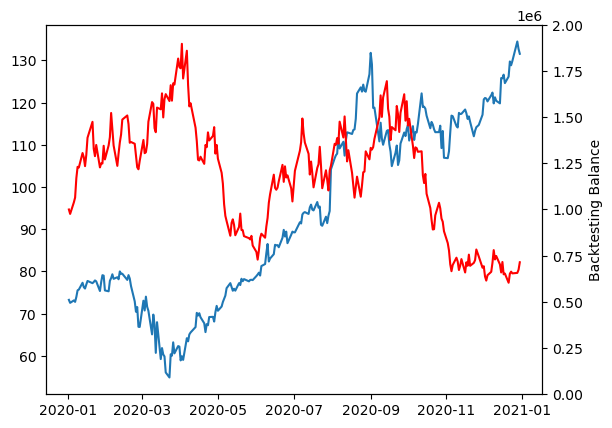

In [7]:
import yfinance as yf
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple, Dict
from random import randrange

# from pandas import DataFrame

def testTicker(ticker: str, start: str, end: str) -> List[float]:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start, end=end)
    prices = data['Close'].to_list()
    arr = [1000000]
    for i in range(1, len(prices)):
        arr.append(arr[i - 1] * (1 + (randrange(-100, 100) / 1000)))
    return arr


def graphTicker(ticker: str, start: str, end: str) -> None:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start, end=end)
    prices = data['Close'].to_list()
    dates = data.index.to_list()
    backtests = testTicker(ticker, start, end)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax2.set_ylim([0, 2_000_000])
    ax2.set_ylabel('Backtesting Balance')
    ax1.plot(dates, prices)
    ax2.plot(dates, backtests, color='red')

    display(data)
graphTicker("AAPL", "2020-01-01", "2020-12-31")

In [2]:
arr = [True, True, False]
print(sum(arr))

2
